*Import all the libraries & Upload the files*

In [14]:
!pip install networkx
import pandas as pd
import networkx as nx
from google.colab import files
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Upload CSV files
uploaded = files.upload()



Saving artists.csv to artists.csv
Saving institutions.csv to institutions (1).csv
Saving relationships.csv to relationships (1).csv
Saving schools.csv to schools (1).csv


**Load the Data: Load each CSV file into a Pandas DataFrame.**

In [16]:
artists_df = pd.read_csv('artists.csv')
institutions_df = pd.read_csv('institutions.csv')
relationships_df = pd.read_csv('relationships.csv')
schools_df = pd.read_csv('schools.csv')

# Print column names to identify the correct names
print("Columns in artists_df:", artists_df.columns)
print("Columns in institutions_df:", institutions_df.columns)
print("Columns in relationships_df:", relationships_df.columns)
print("Columns in schools_df:", schools_df.columns)

#here i printed culumns for checking if there is any error or not


Columns in artists_df: Index(['artistUrl', 'id', 'image', 'nation', 'title', 'totalWorksTitle',
       'year'],
      dtype='object')
Columns in institutions_df: Index(['city', 'country', 'title', 'url'], dtype='object')
Columns in relationships_df: Index(['artistUrl', 'friends', 'influenced_by', 'influenced_on', 'institution',
       'movements', 'school', 'type'],
      dtype='object')
Columns in schools_df: Index(['title', 'url'], dtype='object')


**Check for Missing Values:**

In [17]:
# Check missing values in each dataset
for df, name in zip([artists_df, institutions_df, relationships_df, schools_df],
                    ['Artists', 'Institutions', 'Relationships', 'Schools']):
    print(f'{name} missing values:\n', df.isnull().sum(), '\n')





Artists missing values:
 artistUrl           0
id                  0
image               0
nation             32
title               0
totalWorksTitle     0
year                1
dtype: int64 

Institutions missing values:
 city       2
country    2
title      0
url        0
dtype: int64 

Relationships missing values:
 artistUrl           0
friends          2580
influenced_by    2512
influenced_on    2637
institution      2362
movements          40
school           1966
type                1
dtype: int64 

Schools missing values:
 title    0
url      0
dtype: int64 



**Artists: Look at nationality distribution, total artworks, and active years.**

Artists Nationality Distribution:
nation
American        520
French          402
Italian         269
British         249
German          160
               ... 
Italians          1
Bangladeshis      1
Romanians         1
Bosnian           1
Cameroonian       1
Name: count, Length: 106, dtype: int64
Artists Active Years (based on 'year' column):
count          2995
unique         2202
top       born 1937
freq             24
Name: year, dtype: object


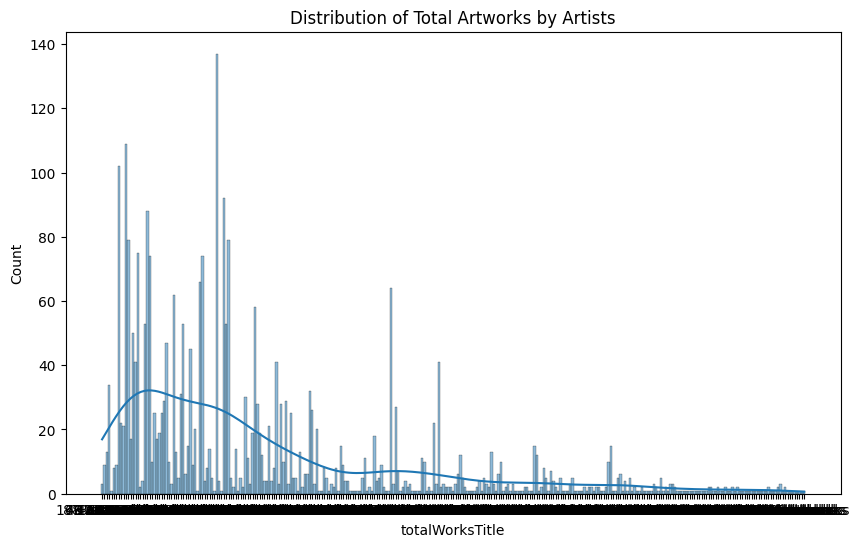

In [18]:
# Nationality distribution
print("Artists Nationality Distribution:")
print(artists_df['nation'].value_counts())

# Active years distribution (if available in 'year' column)
print("Artists Active Years (based on 'year' column):")
print(artists_df['year'].describe())  # Adjust if this doesn't match the active years

# Total artwork distribution (assuming 'totalWorksTitle' represents total works)
plt.figure(figsize=(10,6))
sns.histplot(artists_df['totalWorksTitle'], bins=20, kde=True)
plt.title("Distribution of Total Artworks by Artists")
plt.show()


**Institutions: Look at the distribution of cities and countries.**

Institutions Country Distribution:
country
UK                8
France            7
Germany           6
NY                4
Russia            4
Ukraine           4
CA                4
Italy             3
Belgium           2
New York City     2
Austria           2
PA                2
Australia         1
Belarus           1
Gujarat           1
OH                1
NC                1
Georgia           1
Israel            1
CT                1
MA                1
Norway            1
Poland            1
Mexico            1
Bulgaria          1
Czech Republic    1
Lithuania         1
Netherlands       1
Hungary           1
Denmark           1
MD                1
Victoria          1
Spain             1
Moscow            1
IL                1
Name: count, dtype: int64


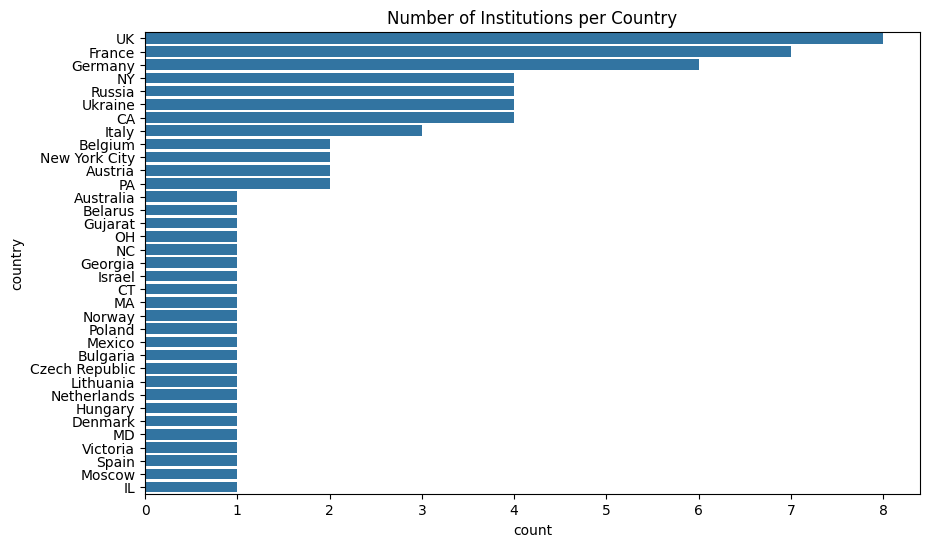

In [20]:
print("Institutions Country Distribution:")
print(institutions_df['country'].value_counts())

plt.figure(figsize=(10,6))
sns.countplot(y=institutions_df['country'], order=institutions_df['country'].value_counts().index)
plt.title("Number of Institutions per Country")
plt.show()


**Step 2: Create Network with NetworkX**

**Create the Network:**

In [21]:
# Initialize directed graph
G = nx.DiGraph()

# Add artists as nodes using 'artistUrl' to ensure consistency
for index, row in artists_df.iterrows():
    G.add_node(row['artistUrl'], nation=row['nation'], artworks=row['totalWorksTitle'])

# Add edges between artists based on influence relationships
for index, row in relationships_df.iterrows():
    artist = row['artistUrl']  # Use 'artistUrl' as the identifier

    # Process 'influenced_by' list
    influenced_by = row.get('influenced_by', None)
    if pd.notna(influenced_by):
        for influence in influenced_by.split(','):
            influence = influence.strip()
            if influence in G:  # Only add edge if the influence exists as a node
                G.add_edge(influence, artist)

    # Process 'influenced_on' list
    influenced_on = row.get('influenced_on', None)
    if pd.notna(influenced_on):
        for inf in influenced_on.split(','):
            inf = inf.strip()
            if inf in G:  # Only add edge if the influenced artist exists as a node
                G.add_edge(artist, inf)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 2996
Number of edges: 1041


**Visualize the Network:**

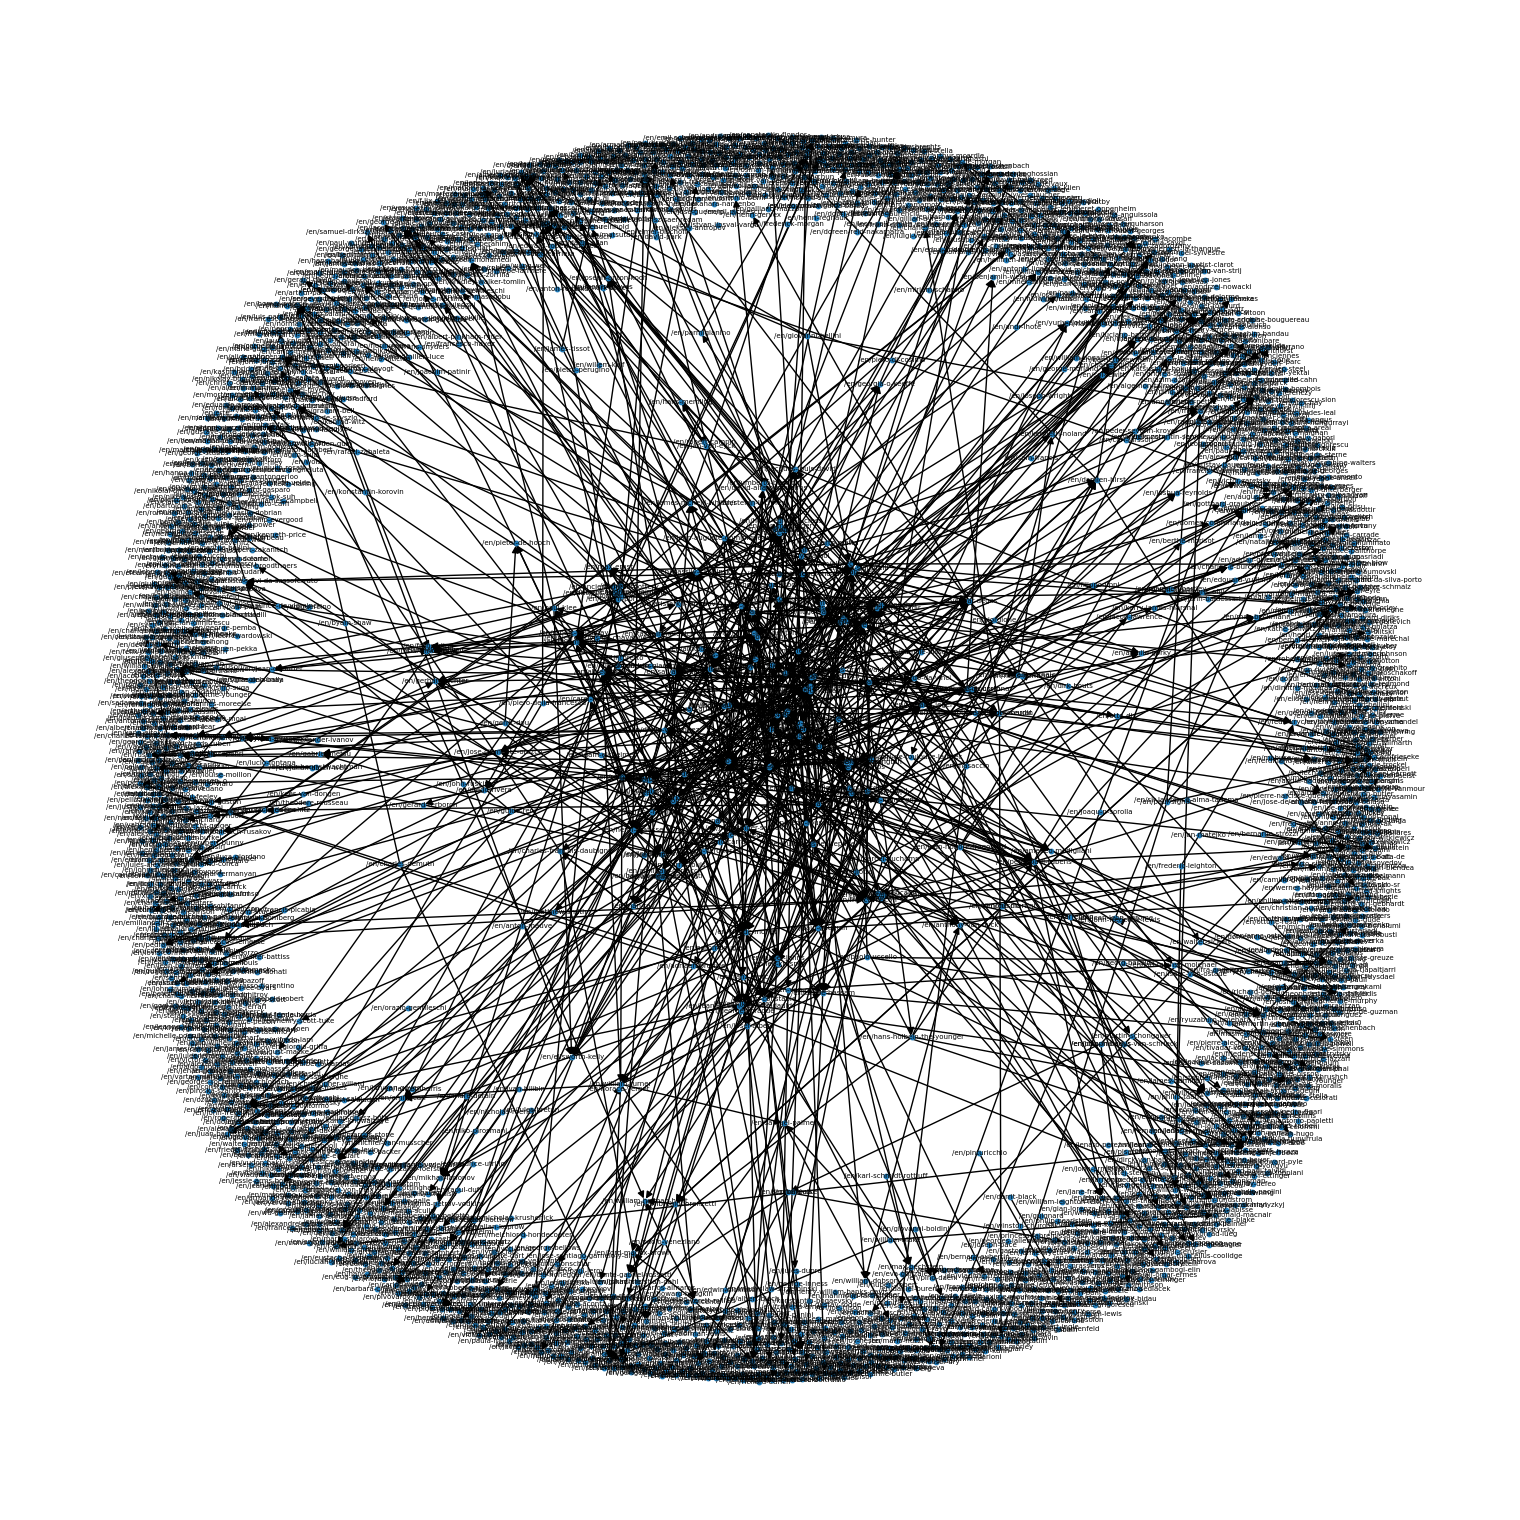

In [29]:
# Basic network visualization
plt.figure(figsize=(15, 15))
nx.draw(G, with_labels=True, node_size=10, font_size=5)
plt.show()



In [23]:
import networkx as nx
import plotly.graph_objects as go

# Assuming G is your NetworkX graph (created as shown earlier)

# Step 1: Filter to show only top 50 influential artists by degree centrality
degree_centrality = nx.degree_centrality(G)
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:50]
G_sub = G.subgraph(top_nodes)  # Create a subgraph with only top nodes

# Step 2: Update node sizes based on degree centrality for the subgraph
node_sizes = [degree_centrality[node] * 2000 for node in G_sub.nodes]  # Scale for visibility

# Step 3: Get positions for each node using a customized spring layout
pos = nx.spring_layout(G_sub, k=0.5, seed=42)

# Step 4: Create edge traces
edge_x = []
edge_y = []
for edge in G_sub.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Create node traces
node_x = []
node_y = []
node_text = []
node_color = []
for node in G_sub.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(degree_centrality[node])  # Color by degree centrality
    node_text.append(f"{node} - Degree Centrality: {degree_centrality[node]:.2f}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    textposition="bottom center",
    textfont=dict(size=10),
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=node_color,
        size=node_sizes,
        colorbar=dict(
            thickness=15,
            title='Degree Centrality',
            xanchor='left',
            titleside='right'
        )
    ),
    text=node_text,
    hoverinfo='text'
)

# Step 6: Plot the network
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Top Influential Artists Network (Top 50 by Degree Centrality)',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="Filtered network visualization of artist influences",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002
                    )],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))
fig.show()


**Community Detection and Coloring**

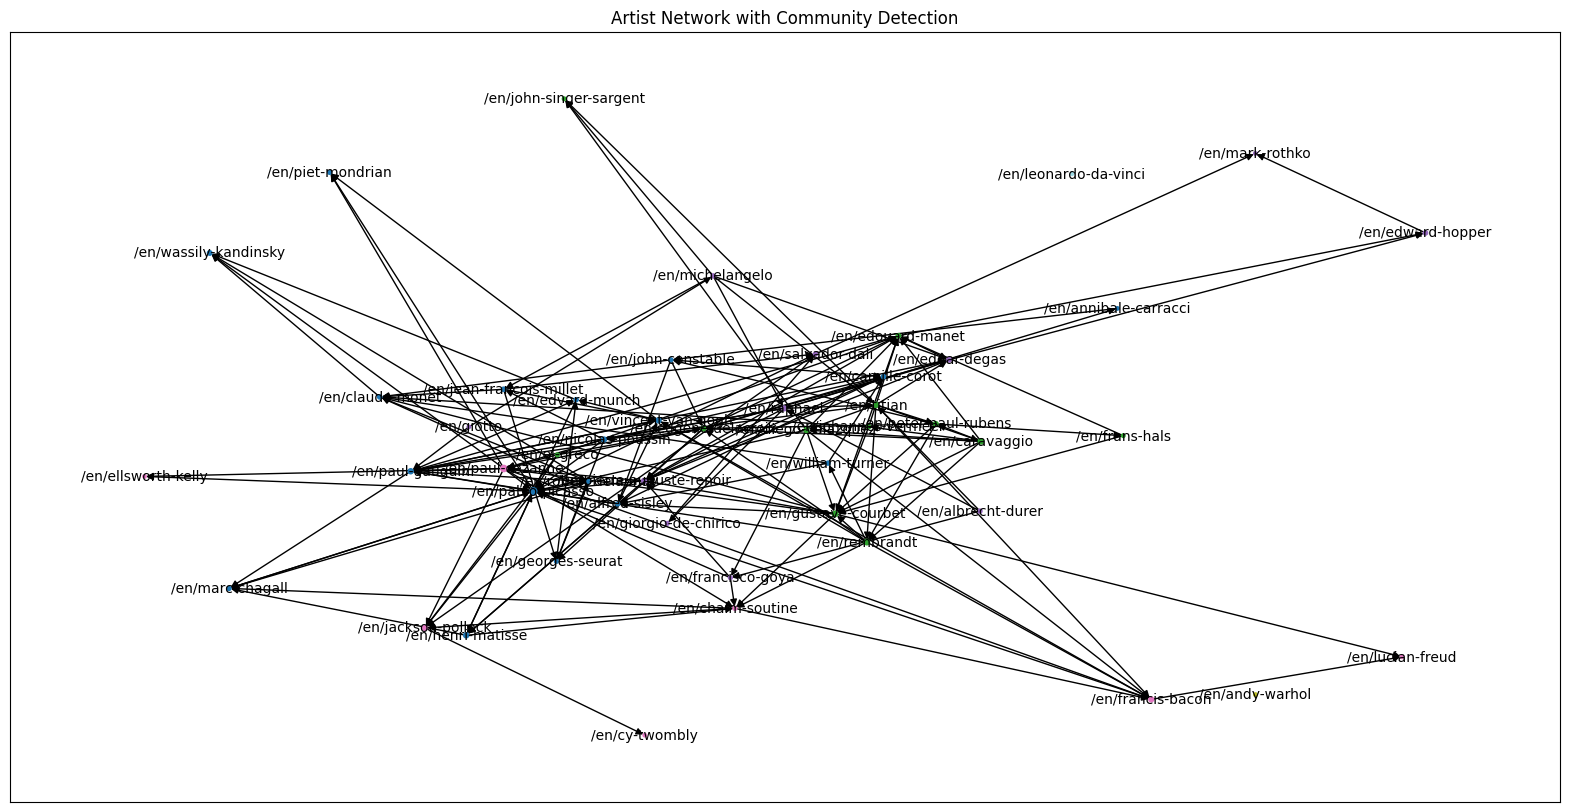

In [33]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# Detect communities
communities = list(greedy_modularity_communities(G_sub))
community_map = {}
for i, community in enumerate(communities):
    for name in community:
        community_map[name] = i

# Assign colors to nodes based on community
colors = [community_map[node] for node in G_sub.nodes]
plt.figure(figsize=(20, 10))
nx.draw_networkx(G_sub, pos, node_color=colors, node_size=node_sizes, cmap=plt.cm.tab20, with_labels=True, font_size=10)
plt.title("Artist Network with Community Detection")
plt.show()


**Highlight Central Nodes with Betweenness Centrality**

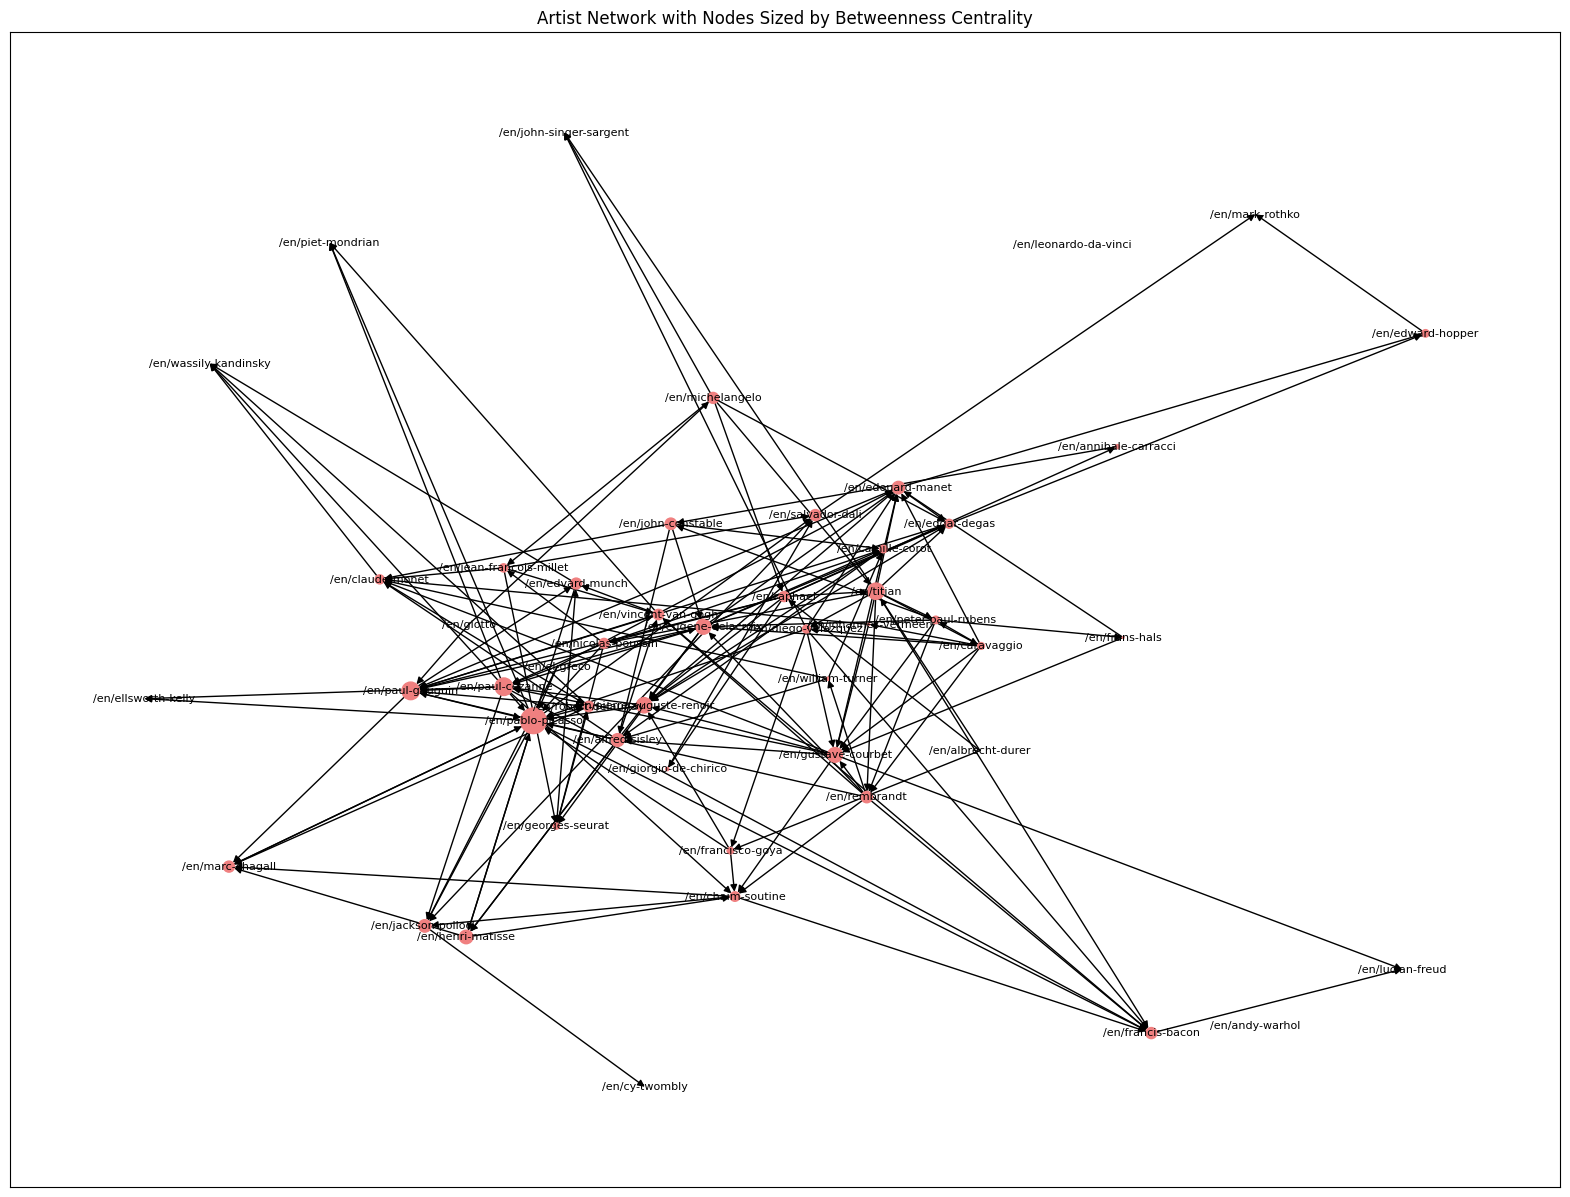

In [34]:
# Calculate betweenness centrality for nodes
betweenness_centrality = nx.betweenness_centrality(G_sub)
node_sizes = [betweenness_centrality[node] * 5000 for node in G_sub.nodes]  # Scale up for visibility

plt.figure(figsize=(20, 15))
nx.draw_networkx(G_sub, pos, node_size=node_sizes, node_color='lightcoral', with_labels=True, font_size=8)
plt.title("Artist Network with Nodes Sized by Betweenness Centrality")
plt.show()


**Use Edge Widths Based on Connection Strength**

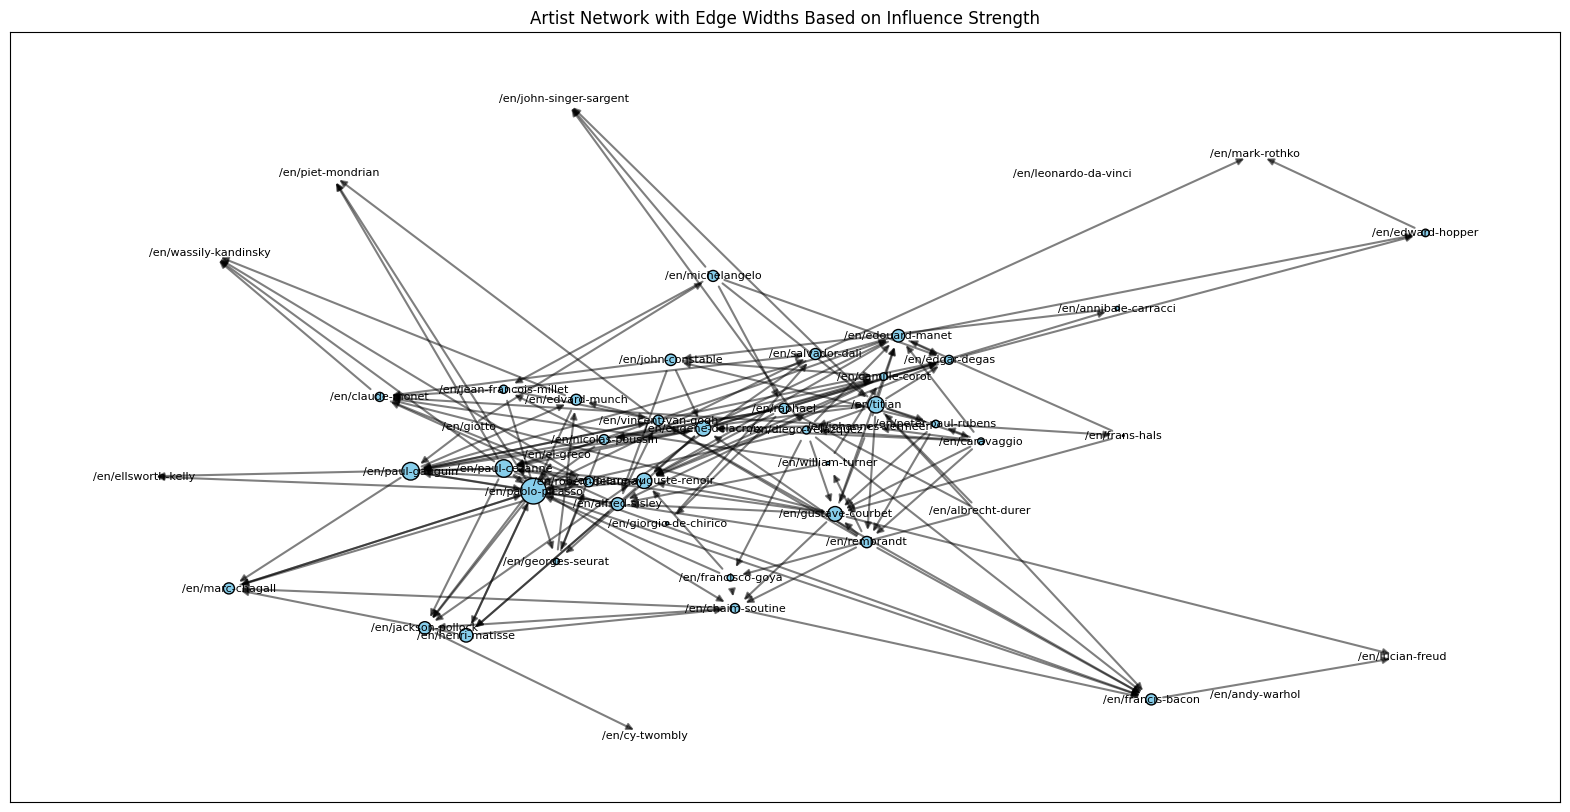

In [36]:
edge_widths = [1 + G_sub[u][v].get('weight', 1) * 0.5 for u, v in G_sub.edges]

plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_edges(G_sub, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G_sub, pos, font_size=8)
plt.title("Artist Network with Edge Widths Based on Influence Strength")
plt.show()


**Step 3: Network Analysis**

In [ ]:
# Degree centrality
degree_centrality = nx.degree_centrality(G)
most_influential_artists = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most Influential Artists by Degree Centrality:")
for artist, score in most_influential_artists:
    print(f'{artist}: {score}')


Most Influential Artists by Degree Centrality:
/en/pablo-picasso: 0.011686143572621035
/en/paul-cezanne: 0.01001669449081803
/en/rembrandt: 0.007679465776293823
/en/gustave-courbet: 0.007345575959933222
/en/caravaggio: 0.007345575959933222
/en/titian: 0.00667779632721202
/en/paul-gauguin: 0.00667779632721202
/en/henri-matisse: 0.00667779632721202
/en/vincent-van-gogh: 0.00667779632721202
/en/pierre-auguste-renoir: 0.006343906510851419


**Community Detection**

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
print("Detected Communities in the Network:", communities)


Detected Communities in the Network: [frozenset({'/en/karl-schmidt-rottluff', '/en/edgar-degas', '/en/henri-de-toulouse-lautrec', '/en/henri-edmond-cross', '/en/marc-chagall', '/en/balcomb-greene', '/en/adalbert-erdeli', '/en/georges-braque', '/en/diego-rivera', '/en/jean-metzinger', '/en/emily-carr', '/en/victor-palmov', '/en/andr-lhote', '/en/richard-diebenkorn', '/en/erich-heckel', '/en/michel-kikoine', '/en/karel-appel', '/en/camille-pissarro', '/en/lionel-noel-royer', '/en/charles-alston', '/en/roman-selsky', '/en/maurice-de-vlaminck', '/en/beauford-delaney', '/en/edouard-manet', '/en/guan-zilan', '/en/pablo-picasso', '/en/ernst-ludwig-kirchner', '/en/antonio-de-la-gandara', '/en/harry-phelan-gibb', '/en/silvestre', '/en/david-alfaro-siqueiros', '/en/franz-marc', '/en/pierre-bonnard', '/en/victor-vasarely', '/en/antoine-watteau', '/en/eugene-delacroix', '/en/frederick-carl-frieseke', '/en/vincent-van-gogh', '/en/pierre-auguste-renoir', '/en/david-park', '/en/max-beckmann', '/en/ma